Credit 1: https://www.freecodecamp.org/news/machine-learning-pipeline/

Credit 2: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

# Import libraries

In [2]:
# Import libraies
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
import requests
from io import StringIO, BytesIO

# Remove missing target and unqualified variables
*   Variables with missing > 50%
*   Variables with flat values > 70%

In [3]:
url = 'https://github.com/kaopanboonyuen/2110446_DataScience_2021s2/raw/main/datasets/hw/titanic_training_dataset_v2.csv'
response = requests.get(url)
response.raise_for_status()

# df = pd.read_csv('https://github.com/kaopanboonyuen/2110446_DataScience_2021s2/raw/main/datasets/hw/titanic_training_dataset_v2.csv')
df = pd.read_csv(BytesIO(response.content))
df = df.dropna(subset=['Survived'])
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Parch', 'Cabin'], axis=1)

In [4]:
df

,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked
0,0.0,3.0,male,22.0,1.0,7.2500,S
1,1.0,1.0,female,38.0,1.0,71.2833,C
2,1.0,3.0,female,26.0,0.0,7.9250,S
3,1.0,1.0,female,35.0,1.0,53.1000,S
4,0.0,3.0,male,35.0,0.0,8.0500,S
...,...,...,...,...,...,...,...
886,0.0,2.0,male,27.0,0.0,13.0000,S
887,1.0,1.0,female,19.0,0.0,30.0000,S
888,0.0,3.0,female,NaN,1.0,23.4500,S
889,1.0,1.0,male,26.0,0.0,30.0000,C


# Create Pipelines for Numerical and Categorical Features
*  SimpleImputer to fill in the missing values.

*  StandardScaler to scale the value to range from 0 to 1.

*  OneHotEncoder to split to many numerical columns for model training.

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

num_cols = ['SibSp','Age', 'Fare']
cat_cols = ['Sex', 'Embarked']

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore'))])

# Create ColumnTransformer to Apply the Pipeline for Each Column Set

In [7]:
from sklearn.compose import ColumnTransformer

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)],
    n_jobs=-1)

# Add a Model to the Final Pipeline

In [8]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=0)
model_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', model)
])

# Display the Pipeline

In [10]:
from sklearn import set_config

set_config(display='diagram')
display(model_pipeline)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['SibSp', 'Age', 'Fare']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('model', DecisionTreeClassifier(random_state=0))])

# Split the Data into Train and Test Sets

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X = df[num_cols+cat_cols]
y = df['Survived']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Training and testing model

In [12]:
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Not survived', 'Survived'], digits=4))

              precision    recall  f1-score   support

Not survived     0.8205    0.8972    0.8571       107
    Survived     0.8036    0.6818    0.7377        66

    accuracy                         0.8150       173
   macro avg     0.8120    0.7895    0.7974       173
weighted avg     0.8140    0.8150    0.8116       173



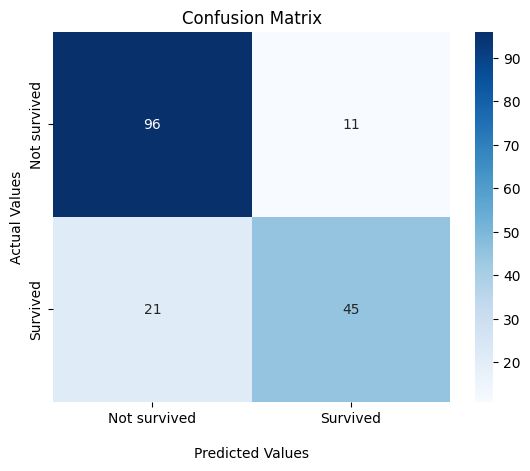

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_matrix(y_test, y_pred):
    conf = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(conf, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values');
    ax.xaxis.set_ticklabels(['Not survived', 'Survived'])
    ax.yaxis.set_ticklabels(['Not survived', 'Survived'])
    plt.show()

conf_matrix(y_test, y_pred)

# GridSearchCV

list of parameters that can be adjusted

In [14]:
model_pipeline.get_params()

{'memory': None,
 'steps': [('col_trans', ColumnTransformer(n_jobs=-1,
                     transformers=[('num_pipeline',
                                    Pipeline(steps=[('impute', SimpleImputer()),
                                                    ('scale', StandardScaler())]),
                                    ['SibSp', 'Age', 'Fare']),
                                   ('cat_pipeline',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('one-hot',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['Sex', 'Embarked'])])),
  ('model', DecisionTreeClassifier(random_state=0))],
 'transform_input': None,
 'verbose': False,
 'col_trans': ColumnTransformer(n_jobs=-1,
                   transformers=[('num_pipeline',
                           

# Add the pipeline to Grid Search

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

param_grid= {'model__criterion':['entropy', 'gini'],
            'model__max_depth': [1,2,3,4,5,6],
            'model__min_samples_leaf':[1,2,3,4,5,6],
            'model__random_state':[0]}
gs_pipeline = GridSearchCV(model_pipeline, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
gs_pipeline.fit(X_train, y_train)
print("Best parameter set: "+str(gs_pipeline.best_params_))

Best parameter set: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__random_state': 0}


              precision    recall  f1-score   support

Not survived     0.8276    0.8972    0.8610       107
    Survived     0.8070    0.6970    0.7480        66

    accuracy                         0.8208       173
   macro avg     0.8173    0.7971    0.8045       173
weighted avg     0.8197    0.8208    0.8179       173



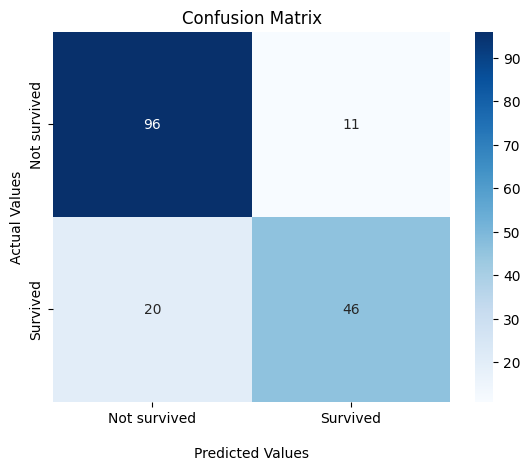

In [16]:
y_pred_gs = gs_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_gs, target_names=['Not survived', 'Survived'], digits=4))
conf_matrix(y_test, y_pred_gs)